In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10, 10

In [2]:
import test_models

Using TensorFlow backend.


In [3]:
import libs.raw_loader
import libs.img_argument
import libs.patch_sequancer
import test_models
import bottlenecks

In [4]:
# loads test data, prepares it and applies the trained models on the data
def load_image(img_id):
    img = np.load("raw/%s_3band_in.npz" % img_id)["arr_0"]
    return img / 255.0

def load_chans(img_id):
    train_mask = None
    for i in range(10):
        chan = i + 1
        mask = np.load("raw/%s_3band_chan%d.npz" % (img_id,chan))["arr_0"] * 1.0
        if train_mask is None:
            train_mask = np.zeros(mask.shape + (10,))
        train_mask[:,:,i] = mask
        
    return train_mask

In [5]:
img_id="6100_2_2"

In [6]:
img = load_image(img_id)

In [7]:
img.shape

(3349, 3391, 3)

In [8]:
img.dtype

dtype('float64')

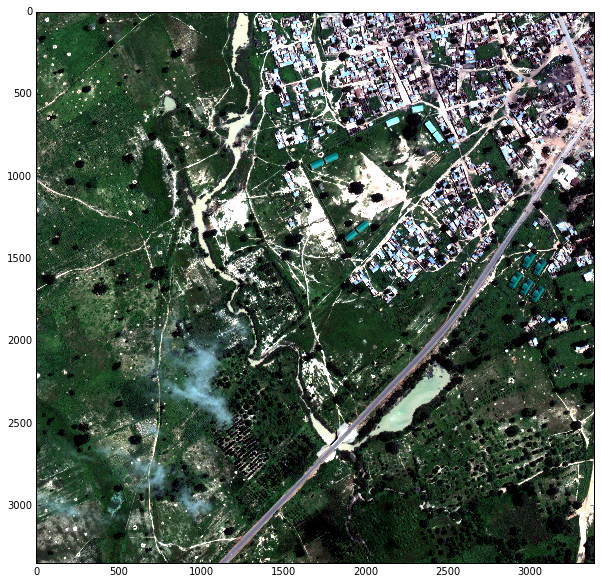

In [9]:
plt.imshow(img)

In [10]:
patch_size = 100
patch_edge =  5    # +/- 5 pixels to interpolate prediction edges  

In [11]:
chan_ids = {
    1 : 'Bldg',
    2 : 'Struct',
    3 : 'Road',
    4 : 'Track',
    5 : 'Trees',
    6 : 'Crops',
    7 : 'Fast H20',
    8 : 'Slow H20',
    9 : 'Truck',
    10 : 'Car',
}

In [12]:
# 26  20decc496cba56857c1fd05453551d084867dfde     0.3594   0.230000    100.0  test_model1
# 21  e6a8060842e35f976e9b5eb764fbad0e12693b03     0.3498   0.200000    200.0  test_model1
# 16  72b74ffcd7e7e25b042262d170f152efa09d188f     0.3159   0.834160  50000.0  test_model2

model_hash = "72b74ffcd7e7e25b042262d170f152efa09d188f"


specs = np.load("outputs/%s_metrics.npy" % model_hash).item()
print specs

{'model': {'ident': 'test_model2', 'patch_size': 100}, 'train': {'acc': 0.83416000000000001, 'loss': 4.2190310746182638, 'recall': array([ 0.97248148,  0.96020683,  0.98570414,  0.85846141,  0.976986  ,
        0.96900299,  0.97837032,  1.        ,  1.        ,  1.        ]), 'support': array([20786, 24175, 11262, 23944, 34718, 18034,  5363,  5427,  5406,  9675]), 'prec': array([ 0.99664727,  0.96833806,  0.99124922,  0.9654314 ,  0.96958523,
        0.94423732,  0.99431495,  0.91240753,  1.        ,  0.99834898]), 'mse': 0.016195831951263485, 'fscore': array([ 0.98441609,  0.9642553 ,  0.9884689 ,  0.90880955,  0.97327155,
        0.95645987,  0.9862782 ,  0.9541978 ,  1.        ,  0.99917381])}, 'tag': '72b74ffcd7e7e25b042262d170f152efa09d188f', 'valid': {'acc': 0.31590000000000001, 'loss': 4.4660573460333373, 'recall': array([ 0.74720358,  0.74955986,  0.12709832,  0.44017359,  0.85747363,
        0.82176907,  0.18796992,  0.26717557,  0.        ,  0.11578947]), 'support': array([17

In [13]:
model_ident   = specs["model"]["ident"]
model_func    = test_models.models()[model_ident]
model_weights = "weights/%s_best.hdf5" % (model_hash)

In [14]:
necks_model = bottlenecks.BottlenecksTransform()

In [15]:
necks_size  = necks_model.allocate(1,100,10).shape

In [16]:
model = model_func(necks_size[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_2 (Dense)              (None, 32)                16416     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 1,065,834
Trainable params: 1,065,834
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
model.load_weights(model_weights)

In [18]:
def patch_processor(patch_in):
    # necks 
    necks = necks_model.allocate(patch_in.shape[0],100,10)    
    for i in range(patch_in.shape[0]):
        necks[i]  = necks_model(patch_in[i])        
    roi = model.predict(necks)

    return roi

def patch_shaper(roi):
    out = np.ones((100,100,10))
    for i in range(roi.shape[0]):
        out[:,:,i] *= roi[i]
    return out

In [19]:
patcher = libs.patch_sequancer.PatchInterpolationSequancer(patch_size,patch_edge,3,10)

In [20]:
predict_mask = patcher(img, patch_processor, shaper=patch_shaper)

   ....timing: [0.00405120849609375, 0.05340170860290527, 65.15464520454407, 0.0018017292022705078, 0.7165958881378174, 0.2346043586730957]


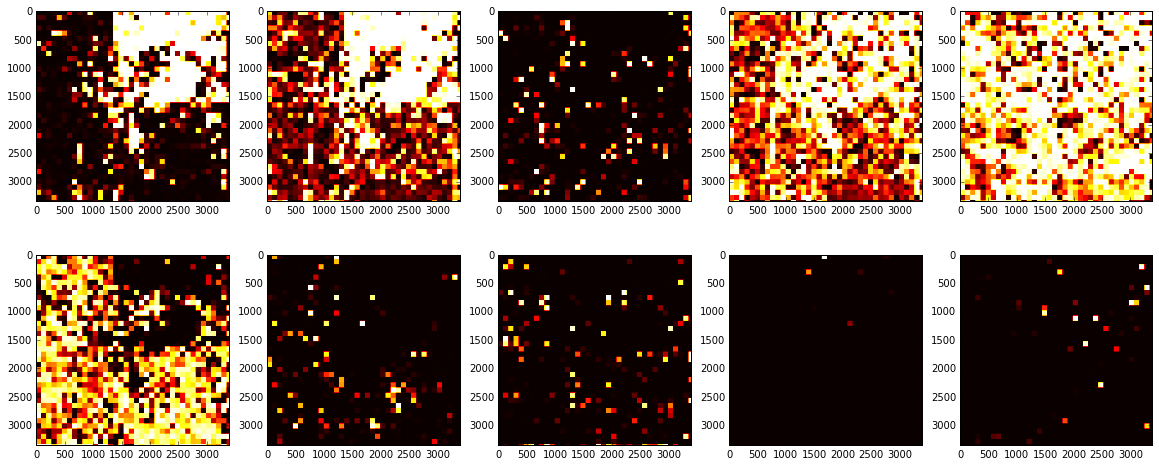

In [21]:
# the predicted ROI areas from masks
fig, axArr = plt.subplots(figsize=(20, 8), nrows=2, ncols=5)
for i in range(2):
    for j in range(5):
        chan = i*5+j
        if chan < 10:
            axArr[i][j].imshow(predict_mask[:,:,chan], cmap="hot")

In [22]:
train_mask = load_chans(img_id)

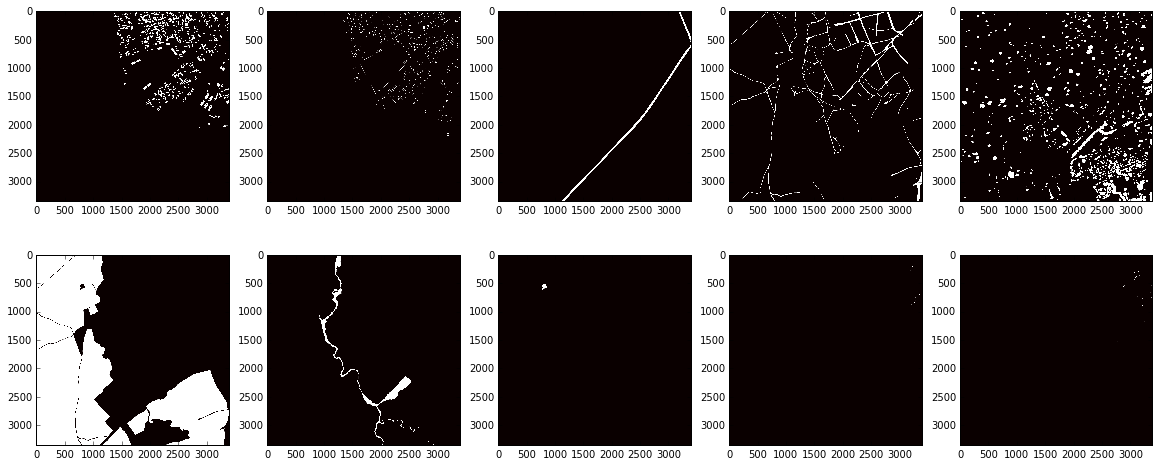

In [23]:
# the predicted actaul masks
fig, axArr = plt.subplots(figsize=(20, 8), nrows=2, ncols=5)
for i in range(2):
    for j in range(5):
        chan = i*5+j
        if chan < 10:
            axArr[i][j].imshow(train_mask[:,:,chan], cmap="hot")

In [24]:
tp_match = predict_mask * train_mask

In [25]:
fp_match = predict_mask * (1.0 - train_mask)

In [26]:
fn_match = (1.0 - predict_mask) * train_mask

In [27]:
# true positives (precision - predicted true and is true)
for i in range(10):
    print (np.sum(tp_match[:,:,i]) / np.sum(train_mask[:,:,i])), " --- ", chan_ids[i+1], "(", i, ")"

0.910581680256  ---  Bldg ( 0 )
0.92146137291  ---  Struct ( 1 )
0.180916040598  ---  Road ( 2 )
0.736413046479  ---  Track ( 3 )
0.772937086383  ---  Trees ( 4 )
0.582912375467  ---  Crops ( 5 )
0.195771563109  ---  Fast H20 ( 6 )
0.00373542963072  ---  Slow H20 ( 7 )
3.68550984685e-11  ---  Truck ( 8 )
0.0226543956388  ---  Car ( 9 )


In [28]:
# false positives ( - predicted true but is false))
for i in range(10):
    print (np.sum(fp_match[:,:,i]) / np.sum(1.0 - train_mask[:,:,i])), " --- ", chan_ids[i+1], "(", i, ")"

0.293582236099  ---  Bldg ( 0 )
0.4590732131  ---  Struct ( 1 )
0.0528077023257  ---  Road ( 2 )
0.553029375834  ---  Track ( 3 )
0.733663935614  ---  Trees ( 4 )
0.327357609634  ---  Crops ( 5 )
0.0309449120521  ---  Fast H20 ( 6 )
0.0345060391161  ---  Slow H20 ( 7 )
0.00136319056196  ---  Truck ( 8 )
0.00972315168732  ---  Car ( 9 )


In [29]:
# false negatives (??? - predicted false but is true )
for i in range(10):
    print (np.sum(fn_match[:,:,i]) / np.sum(train_mask[:,:,i])), " --- ", chan_ids[i+1], "(", i, ")"

0.0894183197443  ---  Bldg ( 0 )
0.0785386270901  ---  Struct ( 1 )
0.819083959402  ---  Road ( 2 )
0.263586953521  ---  Track ( 3 )
0.227062913617  ---  Trees ( 4 )
0.417087624533  ---  Crops ( 5 )
0.804228436891  ---  Fast H20 ( 6 )
0.996264570369  ---  Slow H20 ( 7 )
0.999999999963  ---  Truck ( 8 )
0.977345604361  ---  Car ( 9 )


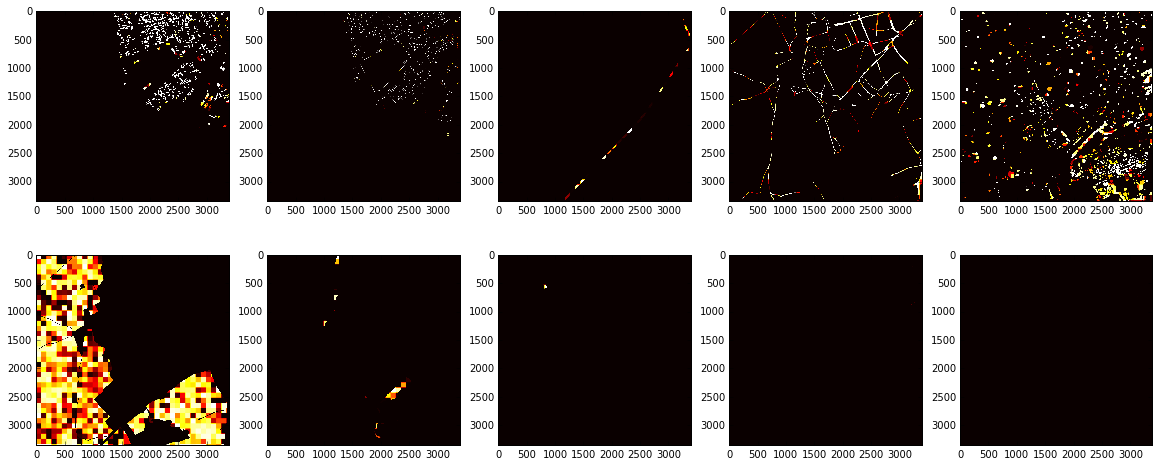

In [30]:
# true positives
fig, axArr = plt.subplots(figsize=(20, 8), nrows=2, ncols=5)
for i in range(2):
    for j in range(5):
        chan = i*5+j
        if chan < 10:
            axArr[i][j].imshow(tp_match[:,:,chan], cmap="hot")

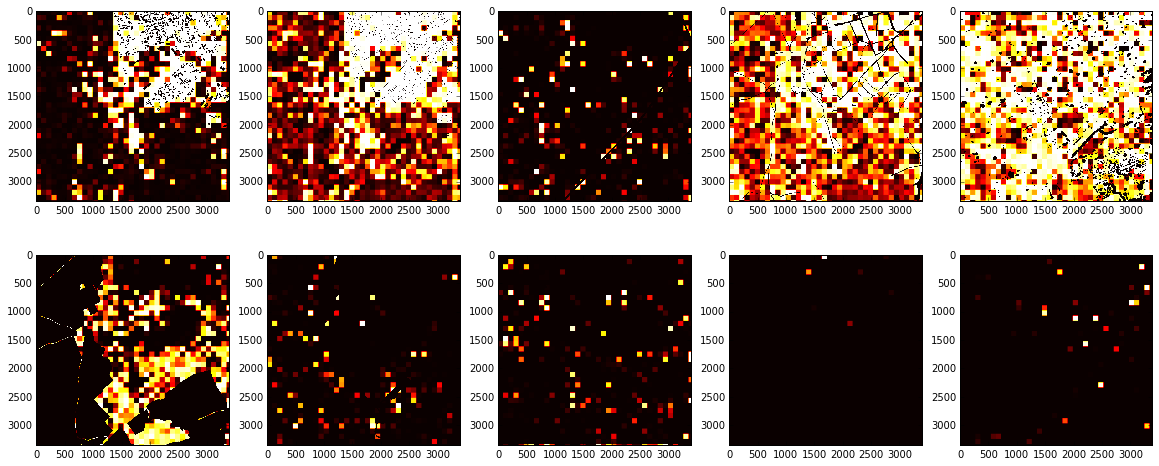

In [31]:
# false positives 
fig, axArr = plt.subplots(figsize=(20, 8), nrows=2, ncols=5)
for i in range(2):
    for j in range(5):
        chan = i*5+j
        if chan < 10:
            axArr[i][j].imshow(fp_match[:,:,chan], cmap="hot")

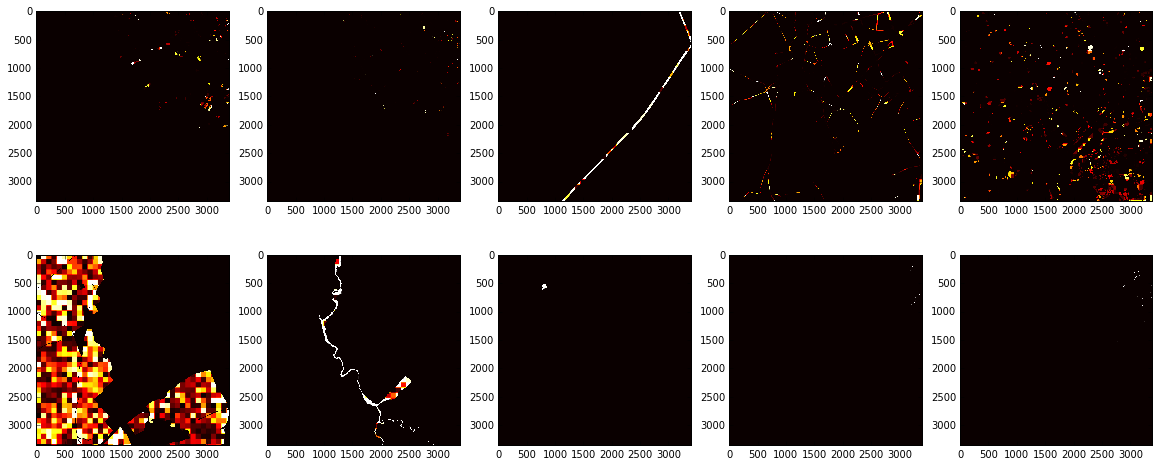

In [32]:
# false negatives (??? - predicted false but is true )
fig, axArr = plt.subplots(figsize=(20, 8), nrows=2, ncols=5)
for i in range(2):
    for j in range(5):
        chan = i*5+j
        if chan < 10:
            axArr[i][j].imshow(fn_match[:,:,chan], cmap="hot")